In [29]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest 
from sklearn.model_selection import KFold, GridSearchCV, RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors, svm
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from functools import reduce

sns.set_style('darkgrid')
sns.set(font_scale=1)
plt.style.use('fivethirtyeight')
sns.set_theme(style="whitegrid", font_scale=1.5)
rcParams_list = ['axes.labelsize', 'xtick.labelsize' ,'ytick.labelsize','legend.fontsize']
matplotlib.rcParams.update({key: 18 for key in rcParams_list})
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['figure.figsize'] = 15, 8
sns.set(font_scale=1.5)

## Loading the Data:
First, data is loaded from the excel file.

In [ ]:
df0 = pd.read_excel('data/material.xlsx')
df0 = df0.rename(columns={'X_26': 'Date', 'X_28':'material'})
print(df0.head(),'\n')
print(df0.info())

    X_0   X_1    X_2   X_3   X_4    X_5   X_6   X_7   X_8   X_9  ...  X_18  \
0  1.81   NaN   0.00  0.00  0.00   0.00  0.00  0.49  0.15  2.86  ...   NaN   
1  2.64  0.87  20.24  4.93  3.04  65.02  1.28  0.59  0.13  2.73  ...   7.3   
2  2.77  0.95   0.00  0.00  0.00   0.00  0.00  0.42  0.13  2.70  ...   7.4   
3  2.70  0.88   0.00  0.00  0.00   0.00  0.00  0.60  0.14  2.68  ...   8.0   
4  2.67  1.02   0.00  0.00  0.00   0.00  0.00  0.59  0.14  2.74  ...   7.6   

   X_19   y_0   y_1   y_2   y_3   y_4   y_5                Date  material  
0   NaN  59.3  60.1  60.3  61.4  59.8  59.7 2012-02-14 10:00:00   0---200  
1   8.3  49.3  48.4  48.6  48.4  48.7  50.9 2012-04-02 10:00:00   0---200  
2   7.7  47.6  47.4  48.2  47.0  48.3  47.1 2012-04-03 10:00:00   0---200  
3   7.4  47.3  47.5  48.8  47.8  48.1  47.8 2012-04-10 10:00:00   0---200  
4   7.9  51.2  49.7  51.0  48.6  50.9  50.4 2012-04-11 10:00:00   0---200  

[5 rows x 28 columns] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 

## Data Visualization:
Plotting the material strength for each material category based on the data acquisition date.

__Questions:__ 
- Is there any change or drift in the sensor readings or the precision of laboratory equipment?
- Should we also consider the temporal aspect of the data? 



Material categories:
 ['0---200' '1---200' '2---250' '7---200' '6---200' '3---150' '4---200'
 '5---200' '8---150']


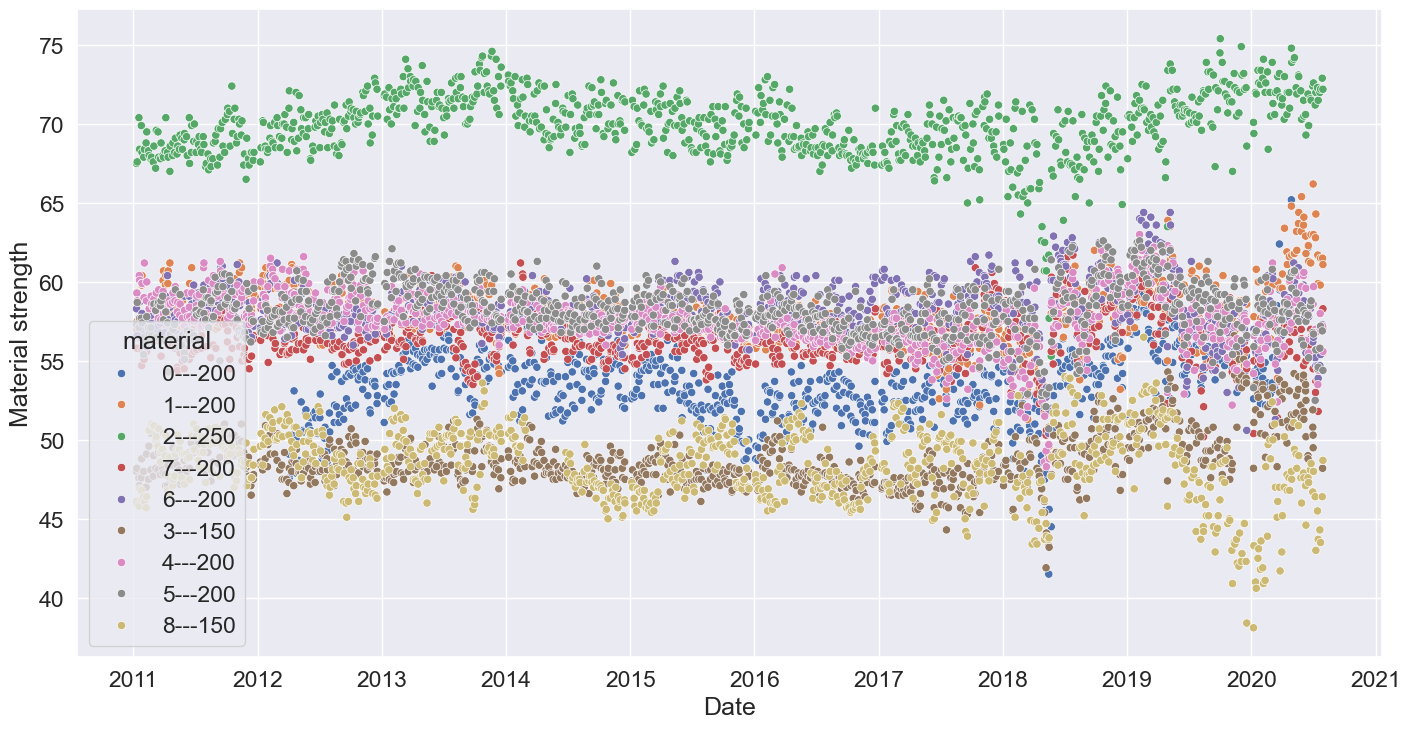

In [31]:
print('\nMaterial categories:\n',df0['material'].unique())
ax = sns.scatterplot(x='Date', y='y', data=df0, hue='material')
ax.set_ylabel('Material strength');

Counting samples in each category shows that different categories have almost equall sizes:

In [32]:
print(df0.groupby(by='material', dropna=False)['material'].count())

material
0---200    809
1---200    966
2---250    966
3---150    964
4---200    964
5---200    966
6---200    975
7---200    966
8---150    924
Name: material, dtype: int64


## Data cleaning: 
Removing the missing values by eliminating the rows with missing values or columns with high number of missing entries.

In [33]:
class strength_model():
    def __init__(self, df0):
        print("\nUpdating the table ...\n")
        self.df = df0

    def cleaning(self, drop_col=[]):
        drop_col += ['X_14', 'X_12', 'X_17', 'X_0']
        self.df = self.df.drop(drop_col, axis=1)
        # column order
        columns = self.df.columns.values
        columns = np.append(columns[columns != 'y'], 'y')
        self.df = self.df[columns]
        # removing missing rows
        self.df = self.df.dropna()

    def __repr__(self):
        return f'Summary of the dataframe: {self.df.info()}'


@property
def dframe(self):    
    self._dframe = self.df
    return self._dframe

strength_model.dframe = dframe

# initiating the class object
st_model = strength_model(df0)

# removing the corrupted columns
st_model.cleaning()
st_model.__repr__()


Updating the table ...

<class 'pandas.core.frame.DataFrame'>
Index: 7965 entries, 1 to 8499
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   X_1       7965 non-null   float64       
 1   X_2       7965 non-null   float64       
 2   X_3       7965 non-null   float64       
 3   X_4       7965 non-null   float64       
 4   X_5       7965 non-null   float64       
 5   X_6       7965 non-null   float64       
 6   X_7       7965 non-null   float64       
 7   X_8       7965 non-null   float64       
 8   X_9       7965 non-null   float64       
 9   X_10      7965 non-null   float64       
 10  X_11      7965 non-null   float64       
 11  X_15      7965 non-null   float64       
 12  X_16      7965 non-null   float64       
 13  X_18      7965 non-null   float64       
 14  X_19      7965 non-null   float64       
 15  y_0       7965 non-null   float64       
 16  y_1       7965 non-null   float64       

'Summary of the dataframe: None'

## Category-based strategies:

However, removing the rows corresponding to the empty cells in $\{X_2:X_6\}$ almost removes half of the training data for the category "2--250", which consequently reduces the prediction accuracy for this category.

Based on several experiments that I did, the features $\{X_2:X_6\}$ are helpful in predicting the material strength related to other categories of material. However, completely removing those features works to the benefit of having a higher prediction for the "2--250" class of material.

Based on the findings, two separate models will be trained in the following parts:

1. A regression model for predicting strength of category "2--250".
2. A regression model for predicting strength of other material types.

For both of the above strategies, we use data samples from all categories in training of the regression model, which increases the models accuracy.

In [34]:
print("Samples per material category after removing missing values in X_2 till X_6:\n",st_model.dframe.groupby(by='material', dropna=False)['material'].count())

Samples per material category after removing missing values in X_2 till X_6:
 material
0---200    803
1---200    960
2---250    519
3---150    951
4---200    959
5---200    961
6---200    935
7---200    961
8---150    916
Name: material, dtype: int64


## Outlier detection:
Inspecting inherent laboratory measurement error of the material strength for each category. 
The following box-and-whisker plot shows the interquartile range (IQR) for each category and the samples which fall beyond the 3rd quartile by $1.5IQR$. 


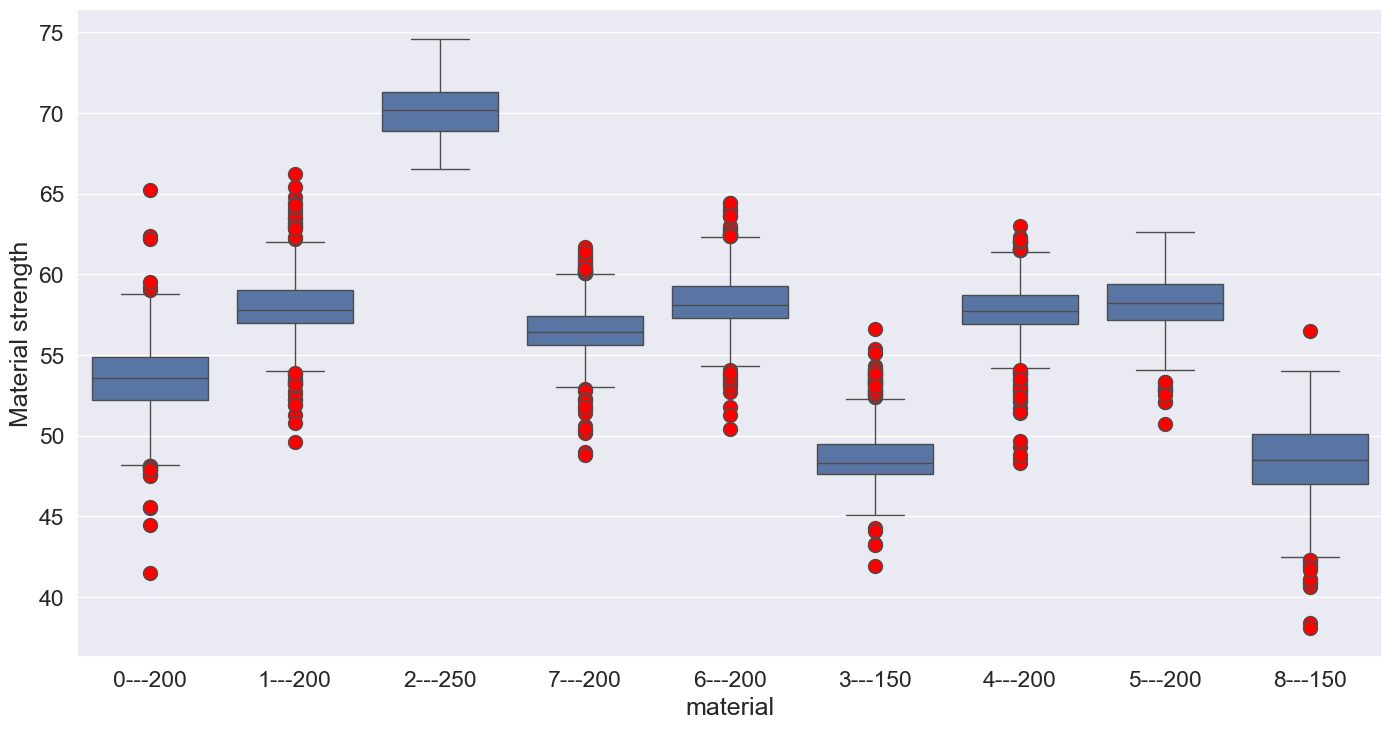

In [35]:
# Outlier inspection based on the material categories
ax = sns.boxplot(x='material', y='y', data=st_model.dframe, flierprops=dict(markerfacecolor='red', markersize=10))
ax.set_ylabel('Material strength');

The outlayers are removed per category of material by leaving out data samples where:
$$
\begin{cases}
      x < Q1-1.5IQR \\
      or \\
      x > Q3+1.5IQR
\end{cases}   

$$



Outlayer detection ....



C:\Users\bbkho\AppData\Local\Temp\ipykernel_141156\3798125053.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_new = pd.concat([df_new, df_mat[df_in]], axis=0,


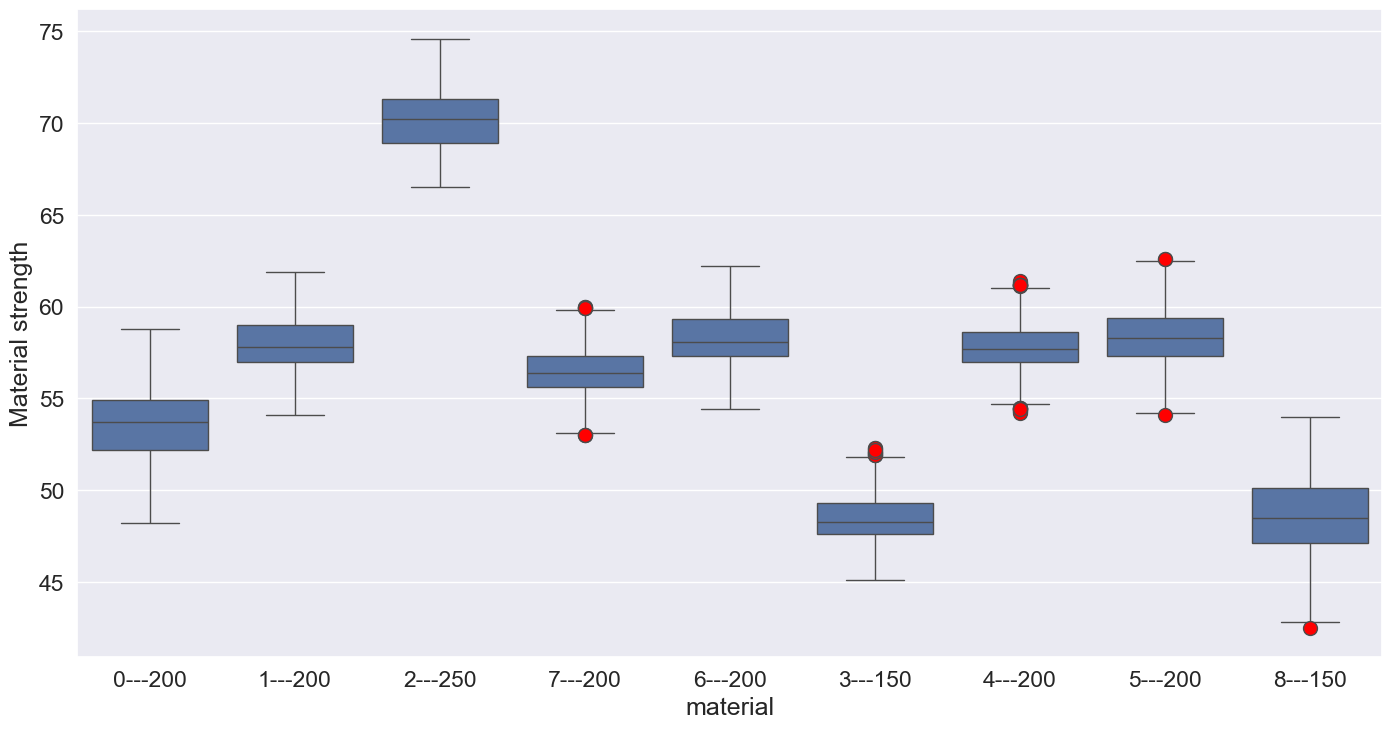

In [36]:
def outlier_remove(self, verbose=True):
    print('\nOutlayer detection ....\n',)
    df_new = pd.DataFrame(columns=self.df.columns)
    for mat in self.df['material'].unique():
        df_mat = self.df[self.df['material'] == mat]
        df_y = df_mat['y']
        Q1 = df_y.quantile(0.25)
        Q3 = df_y.quantile(0.75)
        IQR = Q3 - Q1
        df_in = (df_y > (Q1 - 1.5 * IQR)) & (df_y < (Q3 + 1.5 * IQR))
        # print((df_y < (Q1 - 1.5 * IQR)) | (df_y > (Q3 + 1.5 * IQR)))
        df_new = pd.concat([df_new, df_mat[df_in]], axis=0,
                           join="outer", ignore_index=True)
    if verbose:                           
        ax = sns.boxplot(x='material', y='y', data=df_new, flierprops=dict(
            markerfacecolor='red', markersize=10))
        ax.set_ylabel('Material strength')
        plt.show()
    self.df = df_new

strength_model.outlier_remove = outlier_remove

st_model.outlier_remove()    

Removing the columns which are not required:

In [37]:
def df_drop(self, drop_col):
        self.df = self.df.drop(drop_col, axis=1)
        if hasattr(self,'X_train'):
            self.X_train = self.df.iloc[:, :len(self.df.columns)-1]
            self.X_test = self.X_test.drop(drop_col, axis=1)            

strength_model.df_drop = df_drop

st_model.df_drop(['Date'] + ['y_{}'.format(i) for i in range(6)])


## Test and train split:
The data is split into $80 \%$ training and $20 \%$ testing samples. 

In [38]:
# Splitting the data into train and test batches with 80% and 20% sizes respectively.
def data_split(self, class_list = 'all', test_size=0.20):
    X_train, X_test, y_train, y_test = train_test_split(
        self.df.drop(['y'], axis=1), self.df['y'], test_size=test_size, random_state=2) 
    X_train = X_train.drop('material', axis=1)
    if class_list != 'all':         
        test_ind = reduce((lambda x, y: x | y), [
            X_test['material'] == i for i in class_list])        
        X_test = X_test[test_ind]
        y_test = y_test[test_ind]
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test
    self.test_nrmz = 0
    self.df = pd.concat([self.X_train, pd.DataFrame(self.y_train)], axis=1)

strength_model.data_split = data_split
class_list = [i for i in df0['material'].unique() if i != '2---250']
st_model.data_split(class_list=class_list)

## Preprocessing:
Data distributions should be corrected to mitigate the skewness of each feature and make it more similar to a normal distribution. The histogram of each feature and its skewness calculation show the extent of the issue for each individual feature.

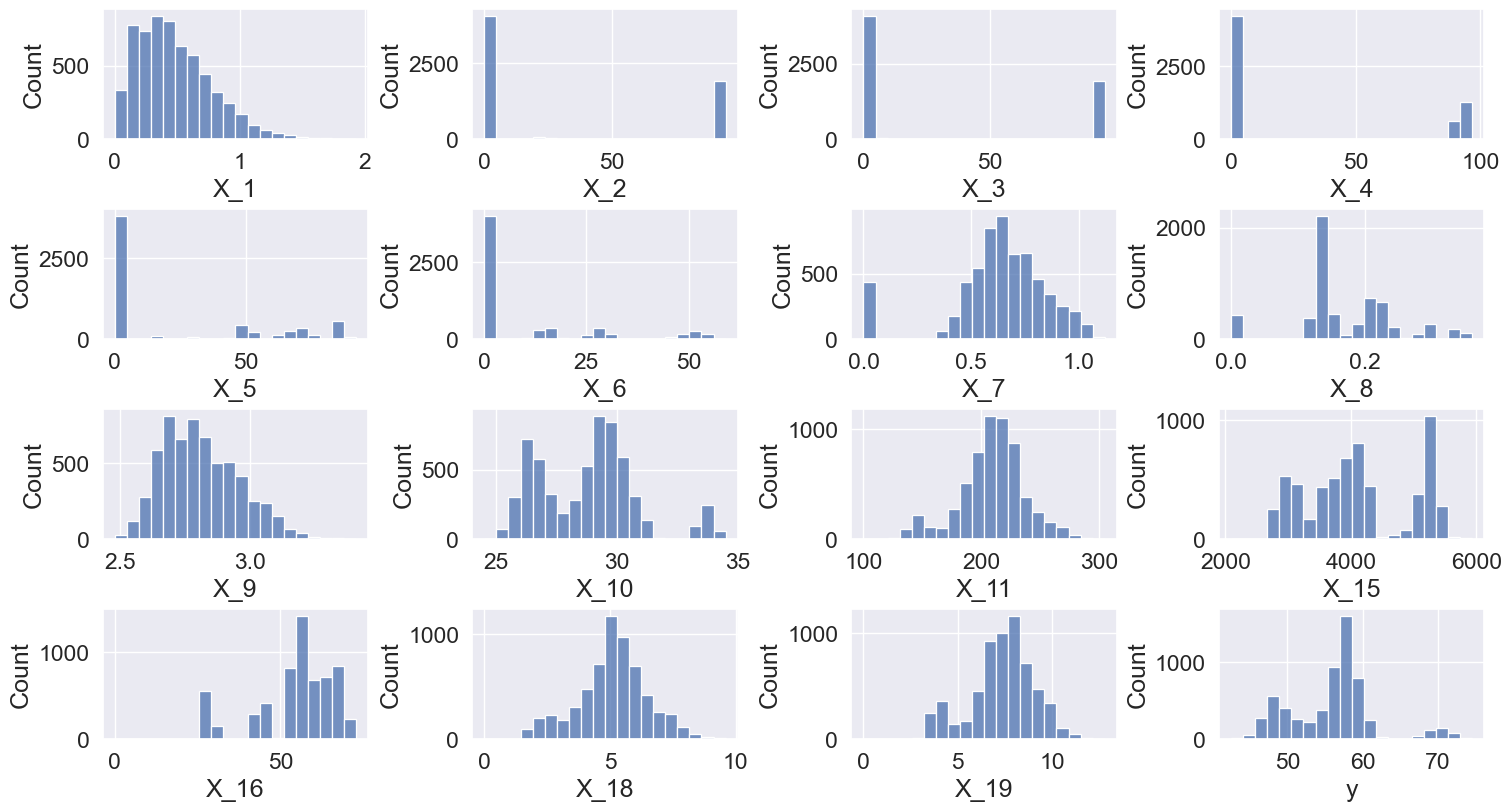


 Skewness measure of each feature:
         X_1       X_2      X_3      X_4       X_5       X_6       X_7  \
0  0.897021  0.791496  0.78549  0.82004  0.792935  1.393742 -1.135354   

        X_8       X_9      X_10      X_11      X_15      X_16      X_18  \
0  0.034992  0.515579  0.487645 -0.385835  0.173113 -1.049653 -0.174377   

       X_19         y  
0 -0.454903  0.500213  


In [39]:
def histograms(self, test=False):
    df_hist = pd.concat([self.X_test, pd.DataFrame(
        self.y_test)], axis=1) if test else self.df

    n_ax = len(df_hist.columns)
    n_col = np.floor(np.sqrt(n_ax)).astype(int)
    n_row = np.ceil(n_ax / n_col).astype(int)
    fig, ax = plt.subplots(n_row, n_col, constrained_layout=True)
    # for cat, ax_i in zip(df_hist.drop('material', axis=1).columns, ax.flatten()):
    for cat, ax_i in zip(df_hist.columns, ax.flatten()):
        sns.histplot(data=df_hist, x=cat, kde=False, bins=20, ax=ax_i)
    plt.show()
    sk_val = df_hist.skew()
    print('\n Skewness measure of each feature:\n',
          pd.DataFrame(sk_val).transpose())

strength_model.histograms = histograms
st_model.histograms() 

Reducing the skewness of each feature via applying box-cox transformation:

$$
\begin{cases}
      y = (x^{\lambda} - 1) / {\lambda},  & if {\lambda} \neq 0 \\      
      log(x),            &      if {\lambda} = 0
\end{cases}   
$$


    


Skew correction is done for training data


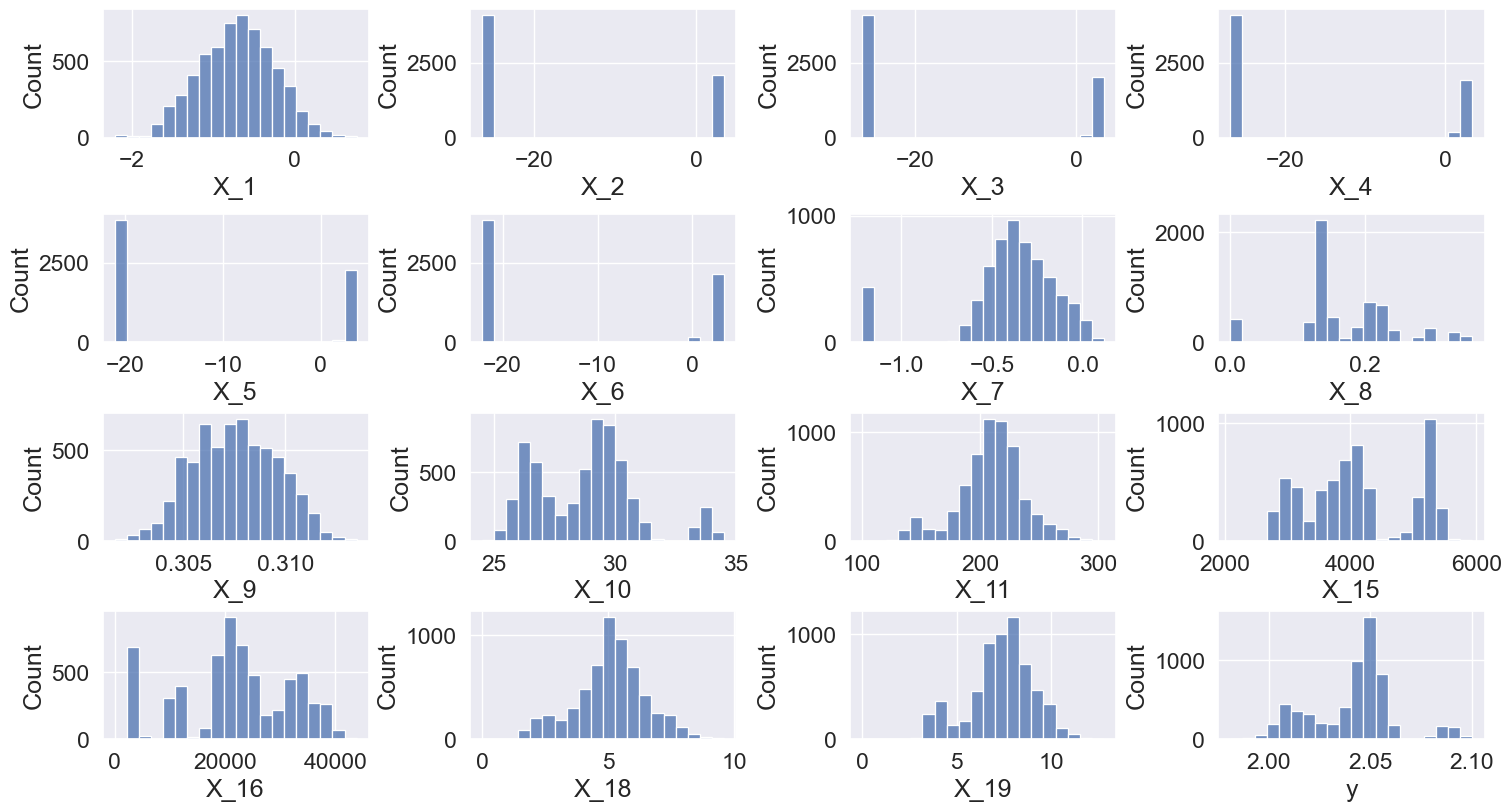


 Skewness measure of each feature:
         X_1      X_2       X_3       X_4       X_5       X_6       X_7  \
0 -0.046046  0.67686  0.677399  0.679143  0.497778  0.501625 -1.589045   

        X_8       X_9      X_10      X_11      X_15     X_16      X_18  \
0  0.034992  0.031882  0.487645 -0.385835  0.173113 -0.27311 -0.174377   

       X_19         y  
0 -0.454903 -0.003362  


In [40]:
def skew_correct(self, test = False):
    if test:        
        for sk_f in self.X_test.columns:            
            i_sk = np.where(self.skew_params['features'] == sk_f)[0]
            if i_sk.size !=0:
                lmbda = self.skew_params['lmbda'][i_sk]
                if self.X_test[sk_f].min() <= 0:
                    self.X_test[sk_f] = self.X_test[sk_f] - self.X_test[sk_f].min()+1e-5
                self.X_test[sk_f] = (self.X_test[sk_f]**lmbda-1) / lmbda                
        print('\nSkew correction is done for test data')
        return
                                
    sk_val = self.df.skew()        
    # Correcting each feature with skewness above 0.5
    sk_features = sk_val.index[np.abs(sk_val) > .5].values
    lmbda_ls, shift_ls = [np.zeros(len(sk_features))]*2    
    for i_sk, sk_f in enumerate(sk_features):
        if self.df[sk_f].min() <= 0:
            shift_ls[i_sk] = self.df[sk_f].min()
            self.df[sk_f] = self.df[sk_f] - self.df[sk_f].min()+1e-5            
        self.df[sk_f], lmbda = stats.boxcox(self.df[sk_f], lmbda=None)
        lmbda_ls[i_sk] = lmbda
    self.skew_params = {'features': sk_features,
                 'lmbda': lmbda_ls, 'shifts': shift_ls}
    self.X_train = self.df.iloc[:, :len(self.df.columns)-1]
    self.y_train = self.df.iloc[:, len(self.df.columns)-1]    
    print('\nSkew correction is done for training data')

strength_model.skew_correct = skew_correct
st_model.skew_correct()
st_model.histograms()

 Normalization of each feature:


Training data is normalized


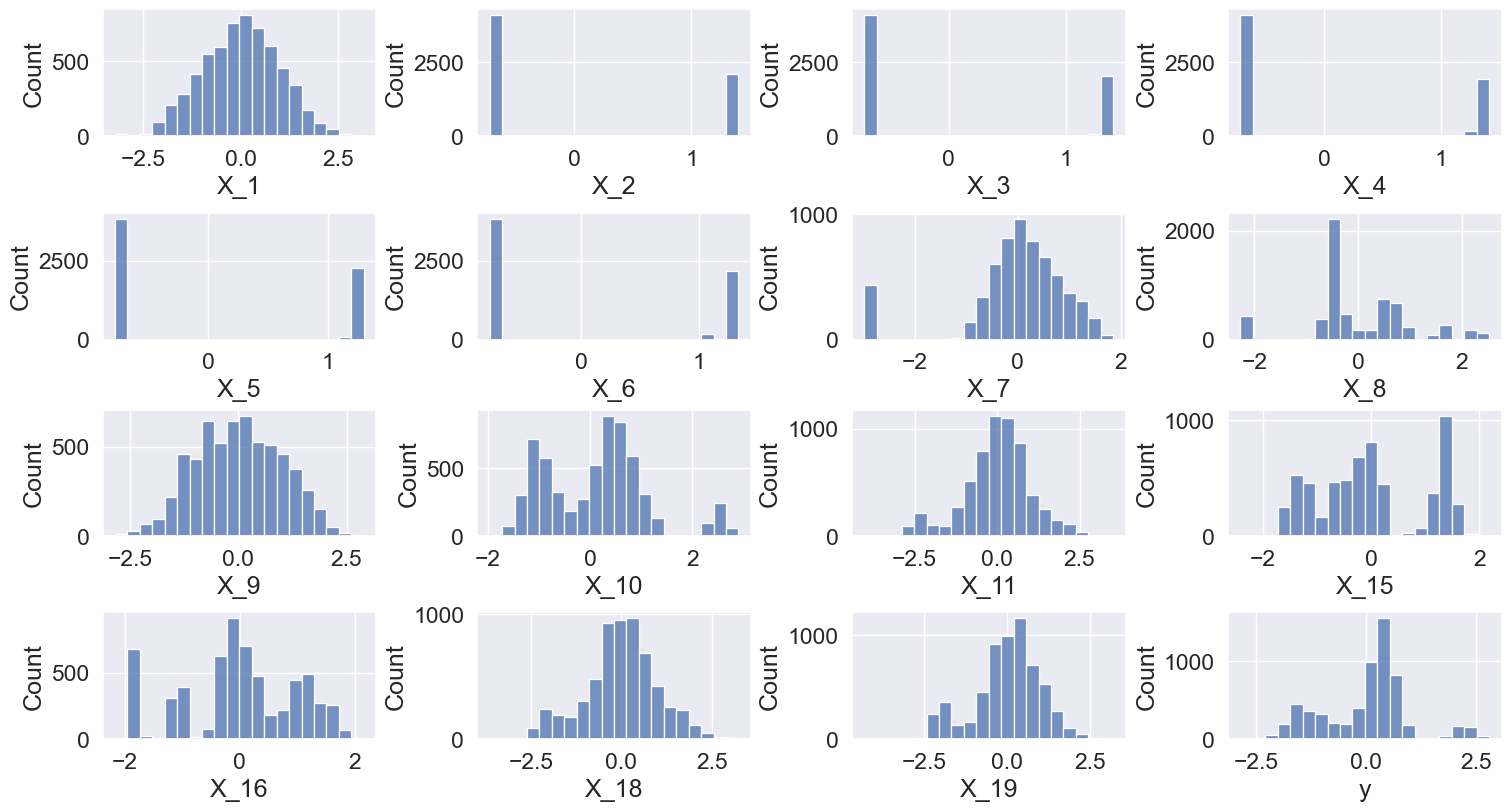


 Skewness measure of each feature:
         X_1      X_2       X_3       X_4       X_5       X_6       X_7  \
0 -0.046046  0.67686  0.677399  0.679143  0.497778  0.501625 -1.589045   

        X_8       X_9      X_10      X_11      X_15     X_16      X_18  \
0  0.034992  0.031882  0.487645 -0.385835  0.173113 -0.27311 -0.174377   

       X_19         y  
0 -0.454903 -0.003362  


,count,mean,std,min,25%,50%,75%,max
X_1,6165.0,1.901696e-17,1.0,-3.231054,-0.695694,0.011091,0.704867,3.159047
X_2,6165.0,2.143730e-16,1.0,-0.717358,-0.717358,-0.717358,1.398732,1.399688
X_3,6165.0,5.301698e-17,1.0,-0.717294,-0.717294,-0.717294,1.400834,1.402104
X_4,6165.0,6.915258e-17,1.0,-0.717086,-0.717086,-0.717086,1.408097,1.410377
X_5,6165.0,-1.060340e-16,1.0,-0.781747,-0.781747,-0.781747,1.270825,1.302609
X_6,6165.0,7.491529e-17,1.0,-0.781236,-0.781236,-0.781236,1.264765,1.337833
X_7,6165.0,-1.532882e-16,1.0,-2.985019,-0.286279,0.110560,0.572646,1.854450
X_8,6165.0,1.774916e-16,1.0,-2.267983,-0.537062,-0.270766,0.661268,2.525337
X_9,6165.0,-1.100160e-14,1.0,-2.850345,-0.724833,-0.044182,0.733775,2.895887
X_10,6165.0,4.673562e-16,1.0,-1.963527,-0.991129,0.224369,0.467469,2.898464


In [41]:
def normalize(self, test=False):
    if test:           
        df_mean = self.norm_params['mean'][self.X_test.columns]
        df_std = self.norm_params['std'][self.X_test.columns]
        self.X_test = (self.X_test - df_mean) / df_std
        # self.y_test = (self.y_test - self.norm_params['mean']['y']) / self.norm_params['std']['y']
        print('\nTest data is normalized')
        return
    df_mean = self.df.mean()
    df_std = self.df.std()
    df_norm = (self.df - df_mean) / df_std
    # df_norm['material'] = self.df['material']
    self.df = df_norm
    self.norm_params = {'mean': df_mean, 'std': df_std}
    self.X_train = self.df.iloc[:, :len(self.df.columns)-1]
    self.y_train = self.df.iloc[:, len(self.df.columns)-1]
    print('\nTraining data is normalized')

strength_model.normalize = normalize
st_model.normalize()
st_model.histograms()

st_model.dframe.describe().transpose()

Studying the pairwise correlation of features shows high correlation between $\{X_2,X_3,X_4\}$ and also $\{X_5,X_6\}$. Hence, the redundant features are removed in the next step of modeling.

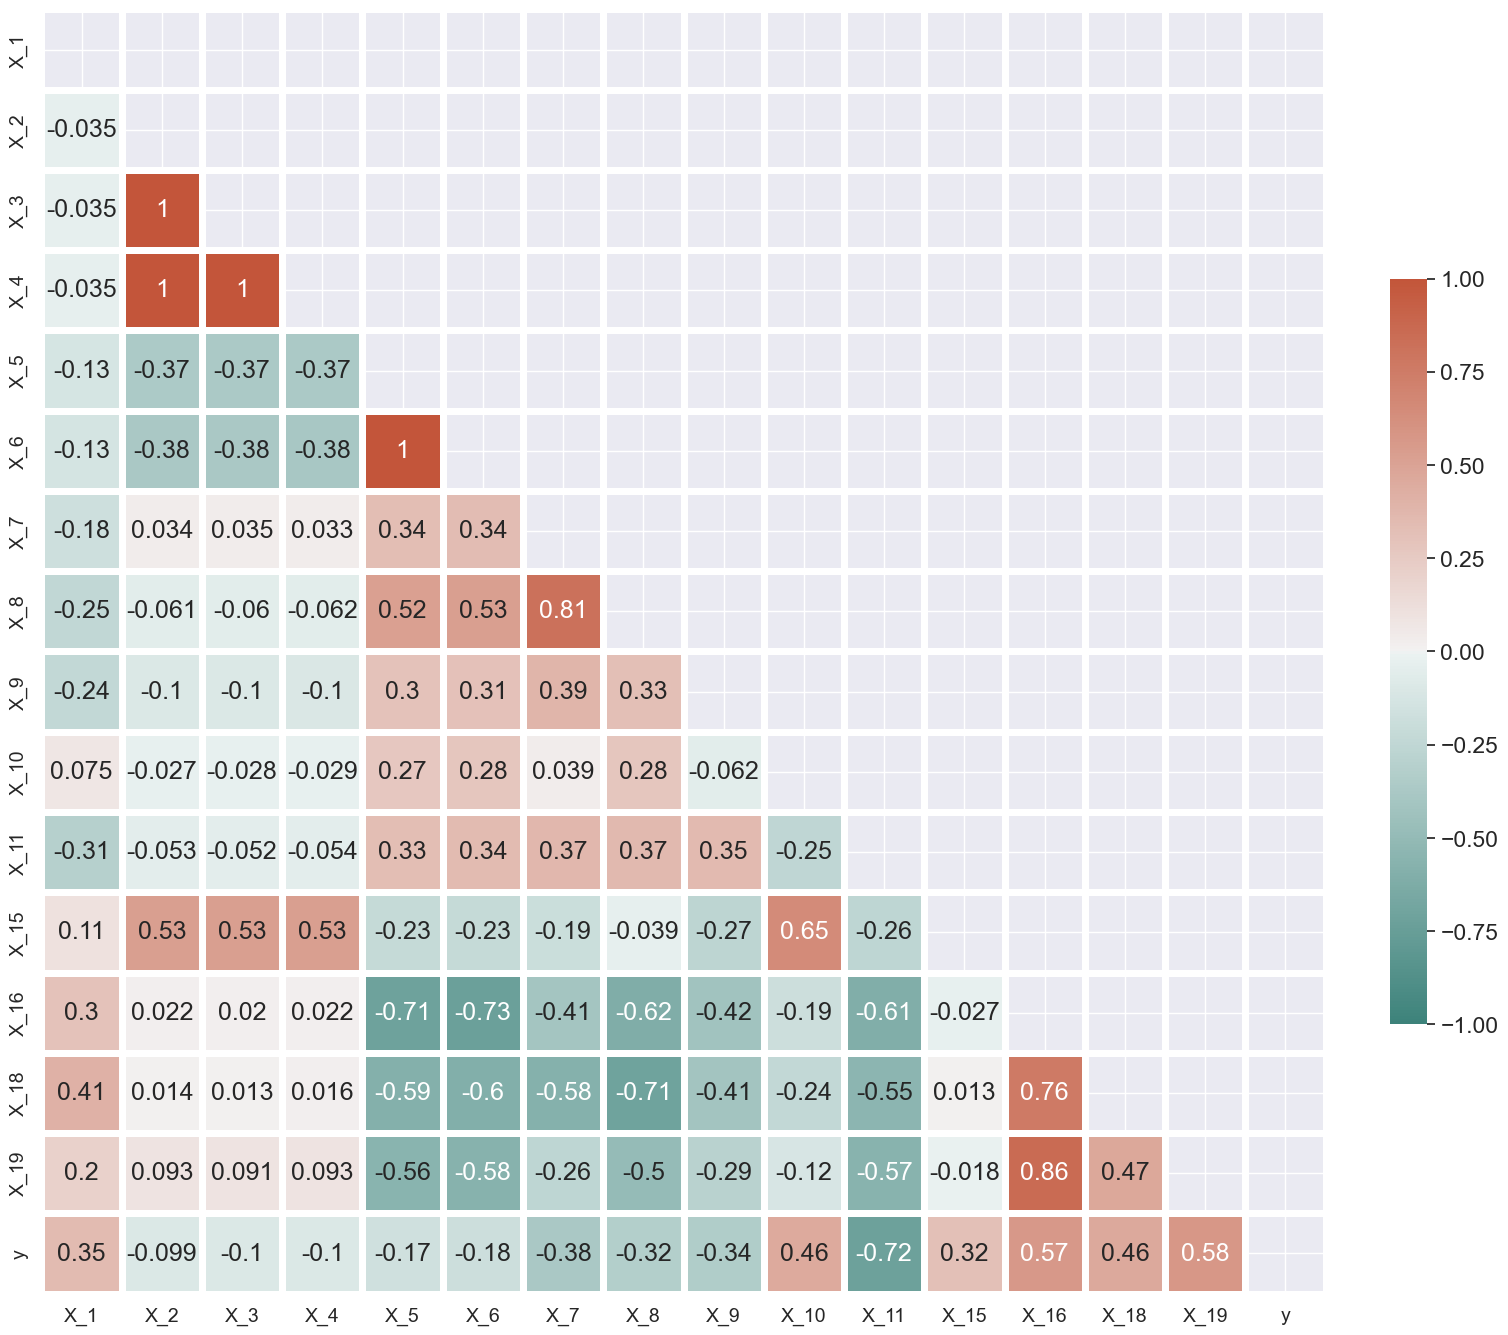

In [42]:
# matplotlib.rcParams['ytick.labelsize']
def corr_matrix(self):
    correlation = self.df.corr()
    mask = np.zeros_like(correlation, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    # ploting the feature relevance matrix
    fig, ax = plt.subplots(figsize=(15, 15), constrained_layout=True)
    cmap = sns.diverging_palette(180, 20, as_cmap=True)
    sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=5, cbar_kws={"shrink": .5}, annot=True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

strength_model.corr_matrix = corr_matrix
st_model.corr_matrix()

st_model.df_drop(['X_2', 'X_3', 'X_6'])

## Modeling the regression problem:
A regression model is trained and evaluated using the conventional test/train splitting routine to predict the material strength. Accordingly, the following steps are performed:
- A feature selection is performed based on the mutual information measure of the features.
- The regression model is trained using the elastic net (linear regression) algorithm due to its simple interpretation of its decision.

## feature relevance profile:
The feature relevance profile is computed based on the mutual information measure for the values of each feature, which studies the nonlinear correlation between each independent variable and the dependant variable (y).

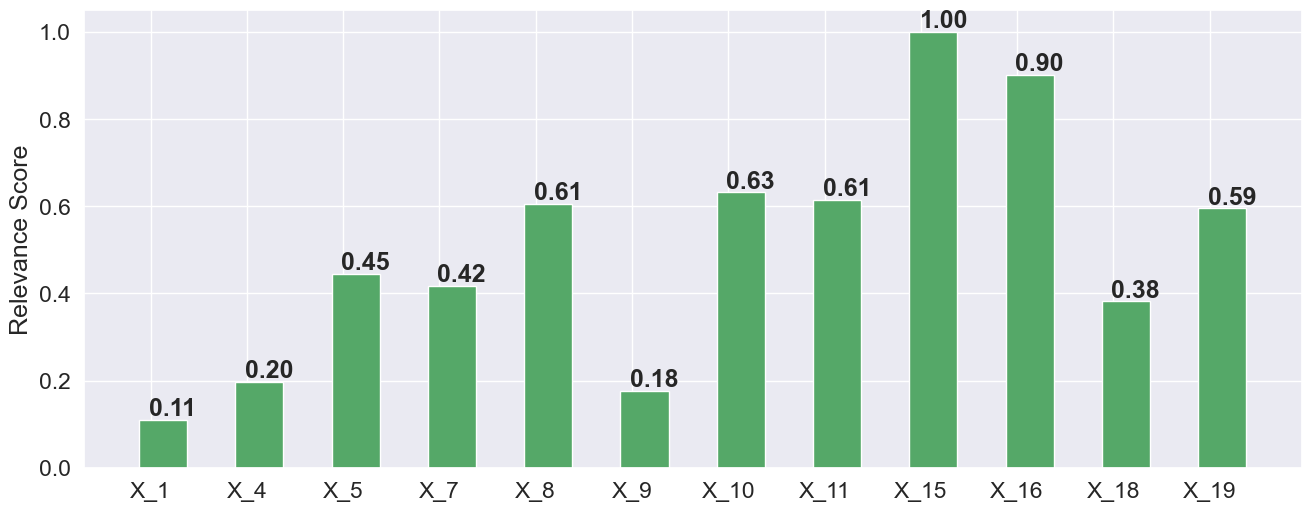


 Featrues ordered by their MI relevance: 
 ['X_15', 'X_16', 'X_10', 'X_11', 'X_8', 'X_19', 'X_5', 'X_7', 'X_18', 'X_4', 'X_9', 'X_1']


In [43]:
# calculate feature relevances using mutual information
def feature_relevacne(self):
    m_features = mutual_info_regression(self.X_train, self.y_train, n_neighbors=3)
    m_features /= np.max(m_features)    
    fig, ax = plt.subplots(constrained_layout=True, figsize = (13, 5))
    x_feat = np.arange(len(self.X_train.columns))
    ax.bar(x_feat + 0.25, m_features, color='g',
        width=0.5, label='mutual information')
    for i, v in zip(x_feat, m_features):
        ax.text(i+0.1, v+0.01, '{:.2f}'.format(v), fontweight='bold')
    ax.set_xticks(x_feat + 0.12)
    ax.set_ylabel('Relevance Score')
    ax.set_xticklabels(self.X_train.columns.tolist())
    plt.show()
    self.m_features = m_features

strength_model.feature_relevacne = feature_relevacne
st_model.feature_relevacne()

# features_optimal = m_features.argsort()[-n_features_optimal:][::-1]
print('\n Featrues ordered by their MI relevance: \n', list(
    st_model.X_train.columns[st_model.m_features.argsort()[::-1]]))    

To perform feature selection, several regression models are trained based on a different number of selected features. Each model is evaluated in a cross-validation setting and based on the MAE performance measure.

C:\Users\bbkho\AppData\Local\Temp\ipykernel_141156\2069722099.py:14: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  results = search.fit(self.X_train, self.y_train.ravel())


Best MAE: 0.370
Best Config: {'sel__k': 12}

>0.731 with: {'sel__k': 1}
>0.608 with: {'sel__k': 2}
>0.481 with: {'sel__k': 3}
>0.444 with: {'sel__k': 4}
>0.432 with: {'sel__k': 5}
>0.424 with: {'sel__k': 6}
>0.400 with: {'sel__k': 7}
>0.388 with: {'sel__k': 8}
>0.372 with: {'sel__k': 9}
>0.372 with: {'sel__k': 10}
>0.372 with: {'sel__k': 11}
>0.370 with: {'sel__k': 12}


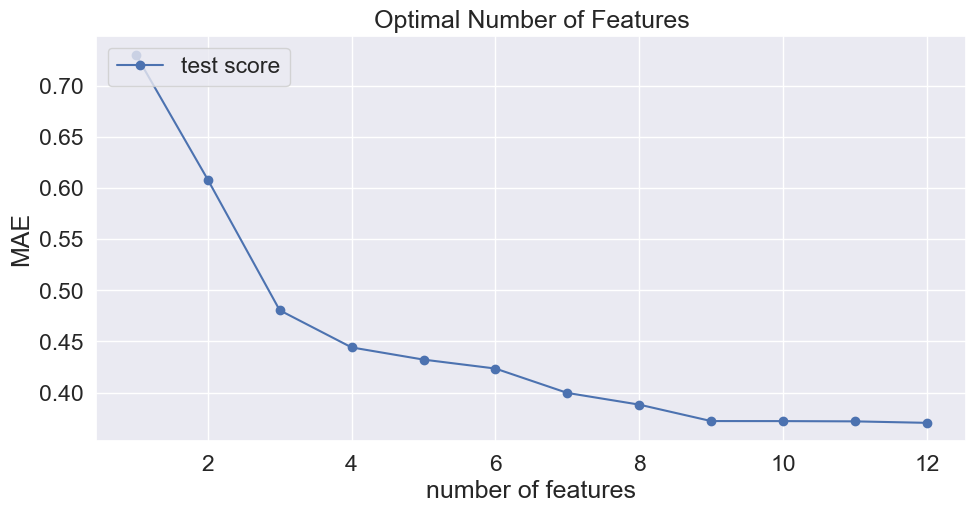

In [44]:
def feature_selection(self, n_splits = 5, model = LinearRegression()):
    # define cross-validation settings
    cv = RepeatedKFold(n_splits = n_splits, n_repeats=1, random_state=1)
    # define the pipeline to evaluate    
    fs = SelectKBest(score_func=mutual_info_regression)
    pipeline = Pipeline(steps=[('sel', fs), ('lr', model)])
    # define the search grid
    grid = dict()
    grid['sel__k'] = [i for i in range(1, self.X_train.shape[1]+1)]
    search = GridSearchCV(
        pipeline, grid,
        scoring='neg_mean_absolute_error', n_jobs=1, cv=cv)
    # perform the search
    results = search.fit(self.X_train, self.y_train.ravel())
    # summarize best performance
    print('Best MAE: %.3f' % -results.best_score_)
    print('Best Config: %s\n' % results.best_params_)
    # summarize all
    means = results.cv_results_['mean_test_score']
    params = results.cv_results_['params']
    for mean, param in zip(means, params):
        print(">%.3f with: %r" % (-mean, param))

    cv_results = pd.DataFrame(results.cv_results_)
    fig = plt.figure(figsize = (10,5))
    plt.plot(cv_results["param_sel__k"],
            -cv_results["mean_test_score"], marker = "o")

    plt.xlabel('number of features')
    plt.ylabel('MAE')
    plt.title("Optimal Number of Features")
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.show()
    self.model = model
    self.cv_results = cv_results

strength_model.feature_selection = feature_selection
model = ElasticNet(alpha=.051, random_state=0)
st_model.feature_selection(n_splits=5, model = model)


## Training the selected model:

Based on the above performance curve, 10 features are selected as the efficient number of features to perform a trade-off between the model's complexity and its performance. The linear regression model is trained using the best 10 features according to their mutual information values.

In [45]:
# The function does feature selection using MI value of the features    
def train_model(self, n_features, model=None):
    # configure to select a subset of features
    fs = SelectKBest(k=n_features, score_func=mutual_info_regression)
    # learn relationship from training data
    fs.fit(self.X_train, self.y_train)
    # transform train input data
    X_train_fs = fs.transform(self.X_train)    
    if model is not None:
        self.model = model
    self.model.fit(X_train_fs, self.y_train)    
    self.fs = fs
    features_optimal = fs.scores_.argsort()[-n_features:][::-1]
    print('\nSelected featrues ordered by their MI relevance:\n',
          list(self.X_train.columns[features_optimal]))
    self.in_feats = self.X_train.columns[np.sort(
        fs.scores_.argsort()[-n_features:][::-1])].values
    print("\nModel information:")
    print('{:}{}'.format('Trained model: ', model))
    print('{:}{}'.format('Input Features: ', self.in_feats))
    if hasattr(self.model,'coef_'):
        print('{:}{}'.format('Coefficients: ', self.model.coef_))
    if hasattr(self.model,'feature_importances_'):
        print('{:}{}'.format('Feature importance: ', self.model.feature_importances_))    
    if hasattr(self.model,'coef_'):
        print('{:}{:.5f}'.format('Offset parameter: ', self.model.intercept_))    

strength_model.train_model = train_model
n_features = 9
model = ElasticNet(alpha=.051, random_state=0)
st_model.train_model(n_features, model)



Selected featrues ordered by their MI relevance:
 ['X_15', 'X_16', 'X_10', 'X_11', 'X_8', 'X_19', 'X_5', 'X_7', 'X_18']

Model information:
Trained model: ElasticNet(alpha=0.051, random_state=0)
Input Features: ['X_5' 'X_7' 'X_8' 'X_10' 'X_11' 'X_15' 'X_16' 'X_18' 'X_19']
Coefficients: [ 0.19506472 -0.08316536  0.          0.43401445 -0.2243957   0.
  0.14642865  0.20872192  0.32945391]
Offset parameter: -0.00000


## Evaluating the selected model on the test data:

In [46]:
def test_model(self):
    # Remove skewness of X_test    
    if 'material' in self.X_test.columns:
        self.X_test = self.X_test.drop('material', axis=1)
    if self.test_nrmz == 0:
        self.skew_correct(test = True)
        
        # Normalizing X_test       
        self.normalize(test=True)
        self.test_nrmz = 1
    # Feature selection transform for test input data
    X_test_fs = self.fs.transform(self.X_test)
    # evaluate the model on test data
    yhat = self.model.predict(X_test_fs)

    # de-normalized the test data to compare with real target values
    yhat = yhat*self.norm_params['std']['y']+self.norm_params['mean']['y']
    lmbda = self.skew_params['lmbda'][-1:]
    yhat = (yhat*lmbda+1)**(1/lmbda)+self.skew_params['shifts'][-1:]

    # evaluate predictions
    mae = mean_absolute_error(self.y_test, yhat)
    mape = np.mean(np.abs(self.y_test - yhat)/np.abs(self.y_test)) *100  # MAPE
    print('\nThe MAE measure for the unseen test data: %.3f' % mae)
    print('\nThe MAPE measure for the unseen test data: {:.3f} %'.format(mape))
    self.mae = mae
    self.mape = mape
    self.predic_y = yhat
    
    self.df_test = pd.concat([self.X_test, pd.DataFrame(self.y_test)], axis=1)
    self.df_test['y_pred'] = yhat
    print('\n', self.df_test.head())
      
strength_model.test_model = test_model

print('\nEvaluating final model on the test data W/O catefory "2---250":...\n')
st_model.test_model()



Evaluating final model on the test data W/O catefory "2---250":...


Skew correction is done for test data

Test data is normalized

The MAE measure for the unseen test data: 2.147

The MAPE measure for the unseen test data: 3.947 %

            X_1       X_4       X_5       X_7       X_8       X_9      X_10  \
6646  0.111639  1.409035 -0.781747  0.032121  0.794416 -0.044182  0.224369   
3602 -1.047212 -0.717086  1.299104  0.304805  0.394973 -0.487639 -0.261830   
3691 -0.519047 -0.717086  1.298100  0.534659  0.394973 -0.187615 -0.261830   
6431 -1.161135  1.408643 -0.781747  0.343351  0.394973  0.361661  0.224369   
6524 -0.277634  1.408487 -0.781747 -0.822390  0.394973 -1.413479  0.224369   

          X_11      X_15      X_16      X_18      X_19     y     y_pred  
6646 -1.450623  1.610186 -0.023108 -0.130446  0.554421  58.4  57.608460  
3602  0.021158 -0.674611 -0.115323 -0.488505  0.554421  58.1  56.193880  
3691 -0.530760 -0.722460 -0.224577 -0.345282  0.378573  59.2  56.536883  

## Other models besides linear regression:
Besides linear regression, other models such as ridge regression, random forest, bayesian regressor, SVR, and kNN are also tried:
- Random forest obtains the smallest MAE over other  models.
- The linear model provides a more interpretable decision making.
- Random forest is a suitable solution when when we have large number of features.

In [47]:
model = RandomForestRegressor(n_estimators = 300 ,  random_state = 0)

print('\nTraining RF regression model based on {} selected features ...'.format(n_features))
st_model.train_model(12, model = model)

print('\nEvaluating RF on the test data W/O catefory "2---250":...\n')
st_model.test_model()


Training RF regression model based on 9 selected features ...

Selected featrues ordered by their MI relevance:
 ['X_15', 'X_16', 'X_11', 'X_10', 'X_8', 'X_19', 'X_5', 'X_7', 'X_18', 'X_4', 'X_9', 'X_1']

Model information:
Trained model: RandomForestRegressor(n_estimators=300, random_state=0)
Input Features: ['X_1' 'X_4' 'X_5' 'X_7' 'X_8' 'X_9' 'X_10' 'X_11' 'X_15' 'X_16' 'X_18'
 'X_19']
Feature importance: [0.00772913 0.00507381 0.0059292  0.01199462 0.00559239 0.01070803
 0.50674946 0.00912594 0.18960599 0.22948394 0.01166651 0.00634099]

Evaluating RF on the test data W/O catefory "2---250":...


The MAE measure for the unseen test data: 1.071

The MAPE measure for the unseen test data: 1.949 %

            X_1       X_4       X_5       X_7       X_8       X_9      X_10  \
6646  0.111639  1.409035 -0.781747  0.032121  0.794416 -0.044182  0.224369   
3602 -1.047212 -0.717086  1.299104  0.304805  0.394973 -0.487639 -0.261830   
3691 -0.519047 -0.717086  1.298100  0.534659  0.394973 

## Training the model for category "2---250":

Now, we repeat the previous steps to train a regression model to only predict material strength for the "2---250" category. As the difference to the first model, the input features $\{X_2,\cdots,X_6\}$ will be excluded altogether.

In [48]:
print('Second regresion model for "2---250" category:\n')
st_model_single_class = strength_model(df0)

print('Droping X_2 till X_6...\n')
drop_col = ['X_{}'.format(i) for i in range(2,7)]
st_model_single_class.cleaning(drop_col = drop_col)
print(st_model_single_class)

st_model_single_class.outlier_remove(verbose = False)

print('\nDroping irrelevant columns...\n')
st_model_single_class.df_drop(['Date'] + ['y_{}'.format(i) for i in range(6)])

print('\nCreating test/train splits...\n')
class_list = [i for i in df0['material'].unique() if i == '2---250']
st_model_single_class.data_split(class_list=class_list)


Second regresion model for "2---250" category:


Updating the table ...

Droping X_2 till X_6...

<class 'pandas.core.frame.DataFrame'>
Index: 8405 entries, 1 to 8499
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   X_1       8405 non-null   float64       
 1   X_7       8405 non-null   float64       
 2   X_8       8405 non-null   float64       
 3   X_9       8405 non-null   float64       
 4   X_10      8405 non-null   float64       
 5   X_11      8405 non-null   float64       
 6   X_15      8405 non-null   float64       
 7   X_16      8405 non-null   float64       
 8   X_18      8405 non-null   float64       
 9   X_19      8405 non-null   float64       
 10  y_0       8405 non-null   float64       
 11  y_1       8405 non-null   float64       
 12  y_2       8405 non-null   float64       
 13  y_3       8405 non-null   float64       
 14  y_4       8405 non-null   float64       
 15  y_5       840

C:\Users\bbkho\AppData\Local\Temp\ipykernel_141156\3798125053.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_new = pd.concat([df_new, df_mat[df_in]], axis=0,


Fixing skewness and normalization:


Correcting the skewness of feature values...


Skew correction is done for training data

Normalizing feature values...


Training data is normalized

Distribution of feature values...



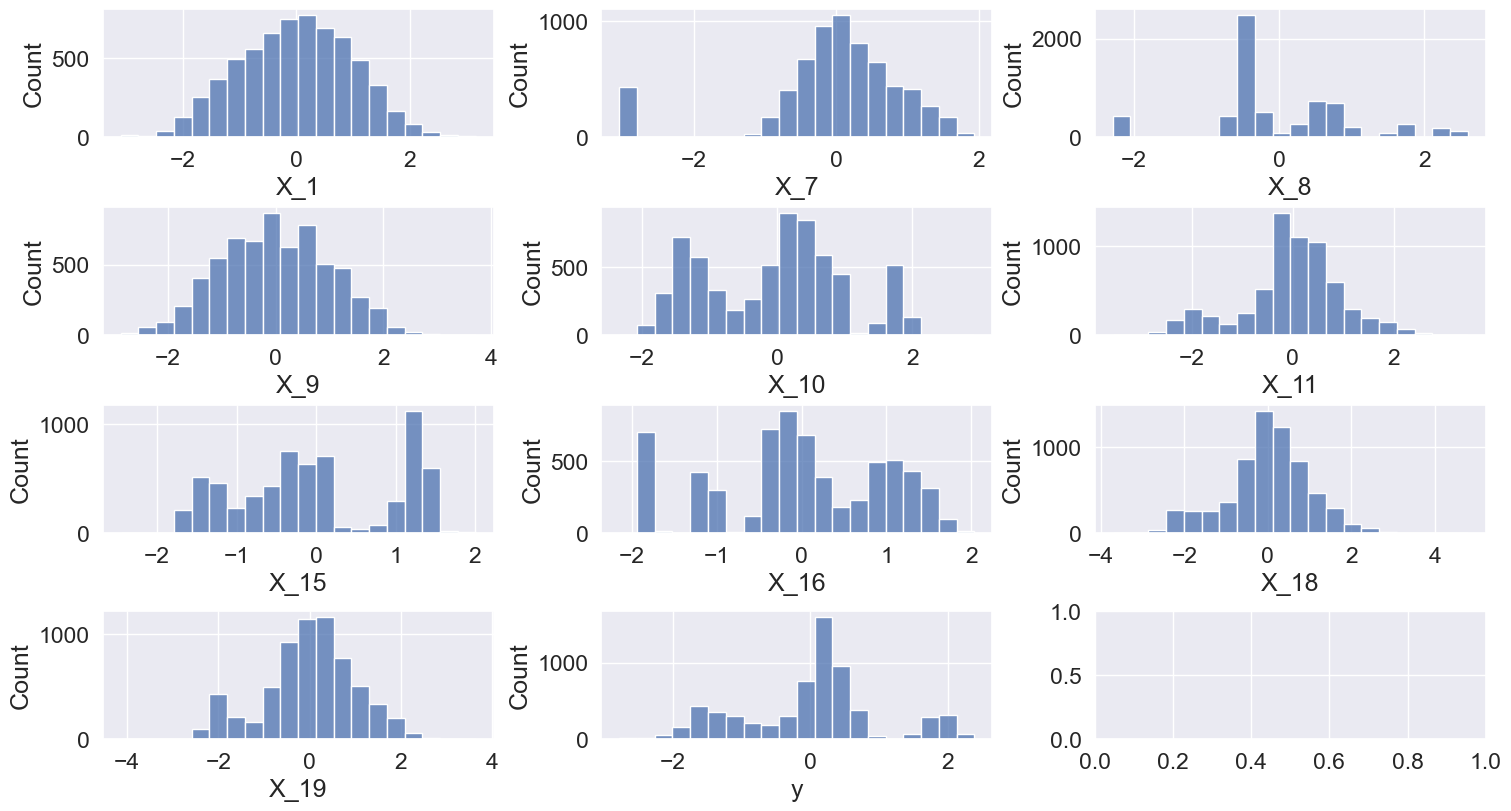


 Skewness measure of each feature:
         X_1       X_7      X_8       X_9      X_10      X_11      X_15  \
0 -0.069161 -1.549493  0.11754  0.023981  0.033864 -0.441091  0.066198   

       X_16      X_18      X_19         y  
0 -0.288523 -0.212342 -0.319154  0.001967  


In [49]:
print('\nCorrecting the skewness of feature values...\n')
st_model_single_class.skew_correct()

print('\nNormalizing feature values...\n')
st_model_single_class.normalize()

print('\nDistribution of feature values...\n')
st_model_single_class.histograms()


Computing the feature relevance for the current feature set ...



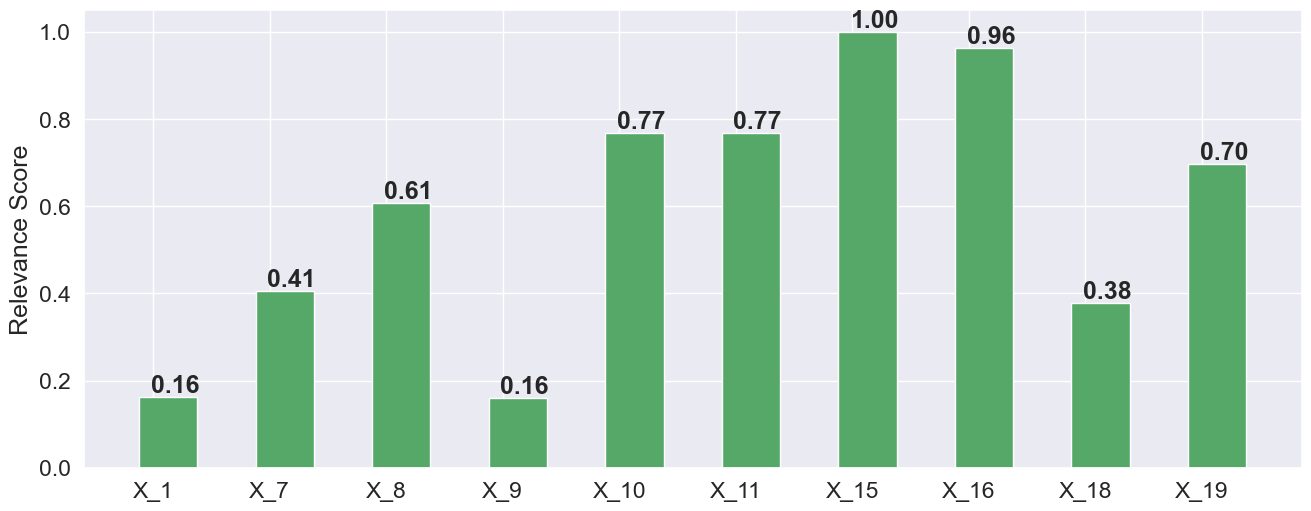


 Featrues ordered by their MI relevance: 
 ['X_15', 'X_16', 'X_10', 'X_11', 'X_19', 'X_8', 'X_7', 'X_18', 'X_1', 'X_9']


In [50]:

print('\nComputing the feature relevance for the current feature set ...\n')
st_model_single_class.feature_relevacne()

print('\n Featrues ordered by their MI relevance: \n', list(
    st_model_single_class.X_train.columns[st_model_single_class.m_features.argsort()[::-1]]))


Featrue selection based on cross-validation ...



C:\Users\bbkho\AppData\Local\Temp\ipykernel_141156\2069722099.py:14: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  results = search.fit(self.X_train, self.y_train.ravel())


Best MAE: 0.362
Best Config: {'sel__k': 10}

>0.705 with: {'sel__k': 1}
>0.576 with: {'sel__k': 2}
>0.440 with: {'sel__k': 3}
>0.395 with: {'sel__k': 4}
>0.388 with: {'sel__k': 5}
>0.384 with: {'sel__k': 6}
>0.375 with: {'sel__k': 7}
>0.365 with: {'sel__k': 8}
>0.362 with: {'sel__k': 9}
>0.362 with: {'sel__k': 10}


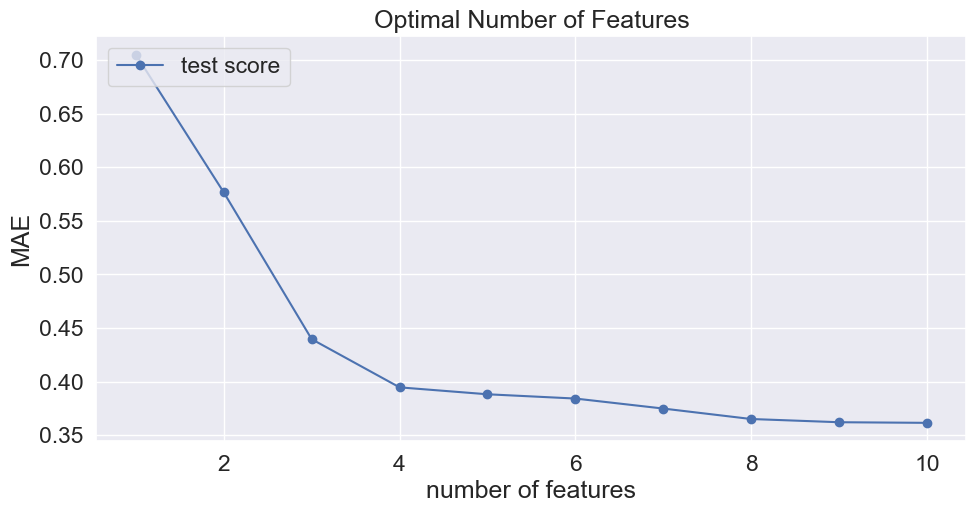

In [51]:
print('\nFeatrue selection based on cross-validation ...\n')
model = ElasticNet(alpha=.1, random_state=0)
st_model_single_class.feature_selection(n_splits=5, model=model)

Based on the above performance curve, 8 features are selected as the efficient number of features to perform a trade-off between the model's complexity and its performance. The linear regression model is trained using the best 8 features according to their mutual information values.

In [52]:
n_features = 8
print('\nTraining final model based on {} selected features...\n'.format(n_features))
model = ElasticNet(alpha=.1, random_state=0)
st_model_single_class.train_model(n_features, model=model)

print('\nEvaluating final model on the test data of category "2---250":...\n')
st_model_single_class.test_model()


Training final model based on 8 selected features...


Selected featrues ordered by their MI relevance:
 ['X_15', 'X_16', 'X_10', 'X_11', 'X_19', 'X_8', 'X_7', 'X_18']

Model information:
Trained model: ElasticNet(alpha=0.1, random_state=0)
Input Features: ['X_7' 'X_8' 'X_10' 'X_11' 'X_15' 'X_16' 'X_18' 'X_19']
Coefficients: [-0.0529034  -0.          0.40429126 -0.25132482 -0.          0.08438665
  0.13775836  0.26663533]
Offset parameter: -0.00000

Evaluating final model on the test data of category "2---250":...


Skew correction is done for test data

Test data is normalized

The MAE measure for the unseen test data: 2.138

The MAPE measure for the unseen test data: 3.023 %

            X_1       X_7       X_8       X_9      X_10      X_11      X_15  \
2517  1.228798 -0.183022 -0.662181  0.017008  1.969167 -2.222238  1.105903   
2621  1.320539 -0.821645 -0.390460 -0.824934  1.678542 -1.887908  0.380850   
2006  0.457743 -0.734708 -0.390460 -1.079625  1.827004 -1.887908  1.462486   

Training a random forest regression model for the "2---250" category:


In [53]:
model = RandomForestRegressor(n_estimators = 300 ,  random_state = 0)

print('\nTraining RF regression model based on {} selected features ...'.format(n_features))
st_model_single_class.train_model(10, model = model)

print('\nEvaluating RF on the test data of category "2---250":...\n')
st_model_single_class.test_model()


Training RF regression model based on 8 selected features ...

Selected featrues ordered by their MI relevance:
 ['X_15', 'X_16', 'X_10', 'X_11', 'X_19', 'X_8', 'X_7', 'X_18', 'X_1', 'X_9']

Model information:
Trained model: RandomForestRegressor(n_estimators=300, random_state=0)
Input Features: ['X_1' 'X_7' 'X_8' 'X_9' 'X_10' 'X_11' 'X_15' 'X_16' 'X_18' 'X_19']
Feature importance: [0.00771998 0.01157016 0.00565106 0.01000875 0.58074761 0.00888985
 0.163814   0.19450491 0.01048425 0.00660945]

Evaluating RF on the test data of category "2---250":...


The MAE measure for the unseen test data: 1.281

The MAPE measure for the unseen test data: 1.813 %

            X_1       X_7       X_8       X_9      X_10      X_11      X_15  \
2517  1.228798 -0.183022 -0.662181  0.017008  1.969167 -2.222238  1.105903   
2621  1.320539 -0.821645 -0.390460 -0.824934  1.678542 -1.887908  0.380850   
2006  0.457743 -0.734708 -0.390460 -1.079625  1.827004 -1.887908  1.462486   
2082 -0.216335 -0.350500 -0